In [36]:
#not working
from qiskit import QuantumCircuit, Aer, execute
import numpy as np

def grovers_contains_negative(list):
    n = len(list)  # Number of items in the list
    num_iterations = int(np.sqrt(n))  # Number of Grover iterations
    qc = QuantumCircuit(n + 1)
    
    # Apply Hadamard gates to create a superposition
    for qubit in range(n + 1):
        qc.h(qubit)
    
    for iteration in range(num_iterations):
        # Implement the oracle to mark negative numbers
        for i in range(n):
            if list[i] < 0:
                qc.x(i)  # Apply an X gate to mark negative numbers
                qc.cz(i, n)  # Apply a controlled-Z gate
                
                # Uncompute the oracle
                qc.x(i)  
                qc.cz(i,n)  
        
        #Grover diffusion operator
        # Apply Hadamard gates to all qubits except the last
        for qubit in range(n):
            qc.h(qubit)
        
        # Apply X gates to all qubits except the last
        for qubit in range(n):
            qc.x(qubit)
        
        # Apply Hadamard gates again to all qubits except the last
        for qubit in range(n):
            qc.h(qubit)
        

        qc.x(n)
        qc.h(n)
        qc.mcz(range(n),n, mode='basic')  # Controlled-Z gate on data qubits

        qc.h(n)
        
        # Uncompute the oracle
        for i in range(n):
            if list[i] < 0:
                qc.x(qubit[i])  # Apply an X gate to uncompute the negative numbers
                qc.cz(qubit[i], qubit[n])  # Apply a controlled-Z gate to uncompute the additional qubit
        
    # Measure the first qubit
    qc.measure(0, 0)
    
    # Execute the circuit on a quantum simulator
    backend = Aer.get_backend('qasm_simulator')
    result = execute(qc, backend, shots=1).result()
    counts = result.get_counts()
    
    # Check if the '1' count (indicating negative numbers) is present
    return '1' in counts

# Example usage:
list_of_numbers = [1, 5, -3, 7, 2, 9]
result = grovers_contains_negative(list_of_numbers)
print("Does the list contain negative numbers?", result)


AttributeError: 'QuantumCircuit' object has no attribute 'mcz'

In [18]:
import pyzx as zx
#Problem 3
#U(pi/2,0,pi)=H
#This circuit is technically equal up to some phase to the ncx gate, but it goes away when we double the circuit according to zx calculus rules.
#We can export this w/ QASM to use w another program (with the phase gone).
def ncx(num_control_qubits):
    qc = zx.Circuit(num_control_qubits+1)
    qubits = [i for i in range(num_control_qubits + 1)]
    for i in range(num_control_qubits):
        qc.add_gate(zx.gates.HAD(qubits[num_control_qubits]))
        qc.add_gate(zx.gates.CNOT(qubits[i], qubits[num_control_qubits]))
        qc.add_gate(zx.gates.HAD(qubits[num_control_qubits]))
    return qc

ncx_circuit = ncx(12)

zx.draw(ncx_circuit)
ncx_graph = ncx_circuit.to_graph()
zx.full_reduce(ncx_graph)
zx.draw(ncx_graph)

In [22]:
import pyzx as zx
#Q3
def pyzx_to_qasm(graph):
    try:
        circuit = zx.extract.extract_circuit(graph)
        zx.optimize.basic_optimization(circuit)
    except Exception as e:
        print("An error occurred during circuit extraction and optimization: ", str(e))
        return None
    try:
        qasm_str = circuit.to_basic_gates().to_qasm()
    except Exception as e:
        print("An error occurred during QASM conversion: ", str(e))
        return None
    
    return qasm_str
pyzx_to_qasm(ncx_graph)

'OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[13];\ncz q[11], q[12];\ncz q[10], q[12];\ncz q[9], q[12];\ncz q[8], q[12];\ncz q[7], q[12];\ncz q[6], q[12];\ncz q[5], q[12];\ncz q[4], q[12];\ncz q[3], q[12];\ncz q[2], q[12];\ncz q[1], q[12];\ncz q[0], q[12];\n'

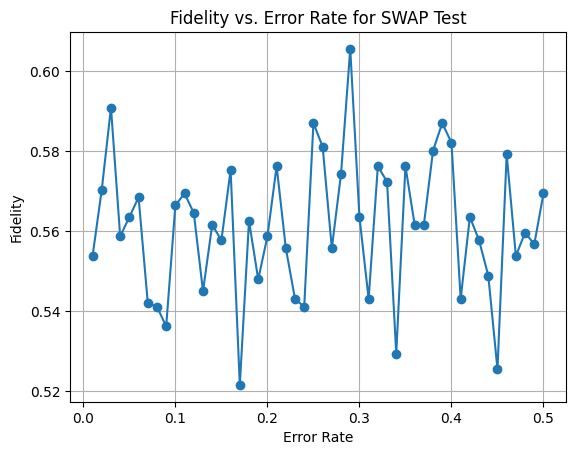

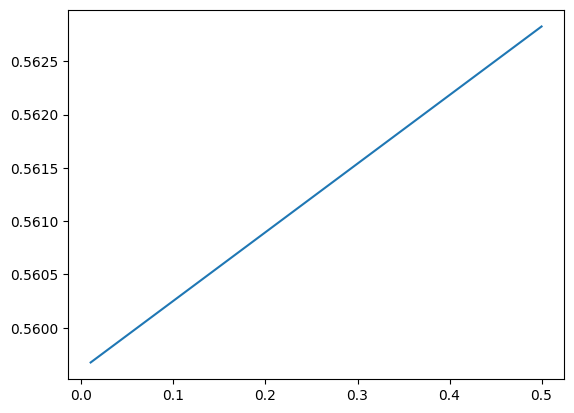

In [10]:
import numpy as np
from qiskit import QuantumCircuit, Aer, execute
from qiskit.providers.aer.noise import NoiseModel, depolarizing_error
import matplotlib.pyplot as plt

def swap_test_circuit(state1, state2):
    n = int(np.log2(len(state1)))  # Determine the number of qubits based on the state dimension
    assert len(state2) == 2 ** n, "Both states must have the same dimension (2^n)."

    circuit = QuantumCircuit(2*n, 1)

    circuit.initialize(state1, list(range(n)))
    circuit.initialize(state2, list(range(n, 2 * n)))

    # Apply the SWAP test
    circuit.h(n)
    circuit.cswap(n, 0, 1)
    circuit.h(n)

    # Measure the ancilla qubit
    circuit.measure(n, 0)
    
    return circuit

def simulate_with_noise(circuit, error_rate):
    noise_model = NoiseModel()
    depolarizing = depolarizing_error(error_rate, 1)
    noise_model.add_all_qubit_quantum_error(depolarizing, ['u1', 'u2', 'u3'])
    
    simulator = Aer.get_backend('qasm_simulator')
    job = execute(circuit, simulator, noise_model=noise_model, shots=1024)
    result = job.result()
    counts = result.get_counts()
    return counts

# Define your two random states (size: 2^n)
def rand_states(num):
    v1 =np.random.randn(2**num)
    state1 = v1 / np.linalg.norm(v1)
    v2 =np.random.randn(2**num)
    state2 = v2 / np.linalg.norm(v2)
    return state1, state2
# Define a range of error rates to test
error_rates = np.linspace(0.01, 0.50, 50)
fidelity_data = []
state1, state2 = rand_states(3)
for error_rate in error_rates:
    circuit = swap_test_circuit(state1, state2)
    counts = simulate_with_noise(circuit, error_rate)
    fidelity = counts['0'] / 1024 
    fidelity_data.append(fidelity)

plt.plot(error_rates, fidelity_data, marker='o')
plt.xlabel('Error Rate')
plt.ylabel('Fidelity')
plt.title('Fidelity vs. Error Rate for SWAP Test')
plt.grid()
plt.show()
x = error_rates
y = fidelity_data
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))


In [23]:
iters = 12
fig, axs = plt.subplots(int(iters/4), 4, figsize=(15, 8))
axs = axs.flatten()
state1, state2 = rand_states(2)
for i in range(iters):    
    error_rates = np.linspace(0.01, 0.50, 25*i + 1)
    fidelity_data = []
    for error_rate in error_rates:
        circuit = swap_test_circuit(state1, state2)  
        counts = simulate_with_noise(circuit, error_rate)  
        fidelity = counts['0'] / 1024 
        fidelity_data.append(fidelity)

    axs[i].plot(error_rates, fidelity_data, marker='o', label='Data')
    axs[i].set_xlabel('Error Rate')
    axs[i].set_ylabel('Fidelity')
    axs[i].set_title(f'Iteration {i + 1}')
    axs[i].grid(True)

    z = np.polyfit(error_rates, fidelity_data, 1)
    p = np.poly1d(z)
    axs[i].plot(error_rates, p(error_rates), "r--", label=f'Fit: {z[0]:.2f}x + {z[1]:.2f}')
    axs[i].legend()
plt.tight_layout()
plt.show()


c:\Program Files\Python310\lib\site-packages\IPython\core\interactiveshell.py:3508: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
